# Genetic programming - Classification (via regression)

Not really a decision tree, which was the assignment, but still a kinda functioning solution computing the iris varieties from the features.

In [1]:
import random
import warnings
import operator

import numpy as np
import pandas as pd

from sklearn import metrics

from deap import gp
from deap import creator, base, tools, algorithms

import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline

try:
    import pydot
except ImportError:
    pydot = None
    
from IPython.display import Image, display

Iris dataset import and examination.

In [2]:
iris = pd.read_csv("iris.csv")

labels = {"Setosa": 0, "Virginica": 1, "Versicolor": 2}
iris = iris.replace({"variety": labels})

iris.head()

sepal.length  sepal.width  petal.length  petal.width  variety
0           5.1          3.5           1.4          0.2        0
1           4.9          3.0           1.4          0.2        0
2           4.7          3.2           1.3          0.2        0
3           4.6          3.1           1.5          0.2        0
4           5.0          3.6           1.4          0.2        0

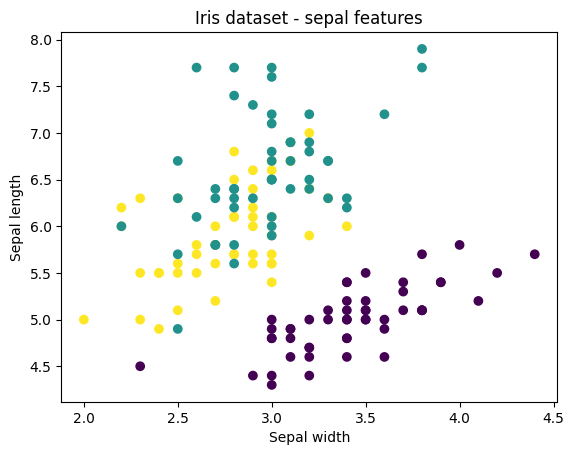

In [3]:
plt.scatter(iris["sepal.width"], iris["sepal.length"], c=iris["variety"])
plt.title("Iris dataset - sepal features")
plt.xlabel("Sepal width")
plt.ylabel("Sepal length") 
plt.show()

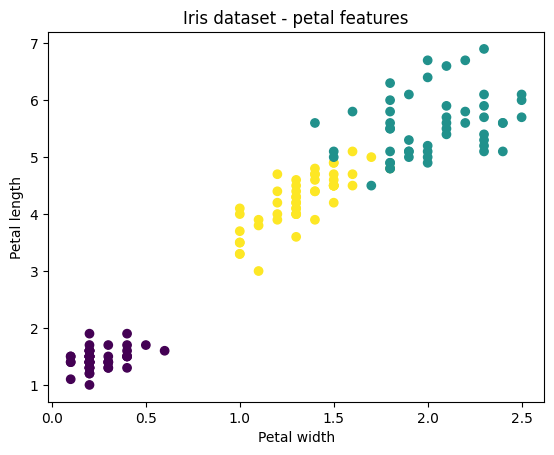

In [4]:
plt.scatter(iris["petal.width"], iris["petal.length"], c=iris["variety"])
plt.title("Iris dataset - petal features")
plt.xlabel("Petal width")
plt.ylabel("Petal length") 
plt.show()

Converting the dataset to numpy.

In [5]:
iris.head()

sepal.length  sepal.width  petal.length  petal.width  variety
0           5.1          3.5           1.4          0.2        0
1           4.9          3.0           1.4          0.2        0
2           4.7          3.2           1.3          0.2        0
3           4.6          3.1           1.5          0.2        0
4           5.0          3.6           1.4          0.2        0

In [6]:
iris = iris.to_numpy(dtype=np.float64)
iris[:5]

array([[5.1, 3.5, 1.4, 0.2, 0. ],
       [4.9, 3. , 1.4, 0.2, 0. ],
       [4.7, 3.2, 1.3, 0.2, 0. ],
       [4.6, 3.1, 1.5, 0.2, 0. ],
       [5. , 3.6, 1.4, 0.2, 0. ]])

In [7]:
iris_x, iris_y = iris[:,:-1], iris[:,-1]

In [8]:
iris_x[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [9]:
iris_y[:5]

array([0., 0., 0., 0., 0.])

Splitting the dataset to train and test parts.

In [10]:
train_to_test_ratio = 4 / 5
num_of_train_samples = int(train_to_test_ratio * len(iris_y))

permutation = np.random.permutation(len(iris_y))
train_idx = permutation[:num_of_train_samples]
test_idx = permutation[num_of_train_samples:]

x_train, x_test = iris_x[train_idx], iris_x[test_idx]
y_train, y_test = iris_y[train_idx], iris_y[test_idx]

print("Number of train samples:", num_of_train_samples, "| Number of test samples:", len(iris_y) - num_of_train_samples)

Number of train samples: 120 | Number of test samples: 30


Setting the Genetig Programming.

In [12]:
# The set of nodes is named "MAIN", input are four floats (x1, x2, x3, x4), output is one float (y)
pset = gp.PrimitiveSetTyped("MAIN", [float, float, float, float], float)

# Terminals
pset.addTerminal(0.0, float)
pset.addTerminal(1.0, float)
pset.addTerminal(2.0, float)


# Non-terminals
def div(a, b):
    return a / b if b != 0 else 0

pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.sub, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)
pset.addPrimitive(div, [float, float], float)

In [13]:
def get_classes(func, x):
    return list(map(lambda *args: int(func(*args)) % 3, *(x.T))) # We round the output value and get the categorization to categories 0, 1, and 2


def fitness(ind, x, y):
    func = toolbox.compile(expr=ind) # We create a function defined by the individual
    vals = get_classes(func, x) # We call the function on data
    accuracy = metrics.accuracy_score(y, vals)
    
    return accuracy, len(ind) # We compute the accuracy and return it along the size of the individual


# Defining classes for the individual
# We want to keep the individual small. This is realized by subtracting a multiple of a size of the individual from the accuracy.
creator.create("FitnessWithRegularization", base.Fitness, weights=(1.0, -0.1))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessWithRegularization)

# Setting the algorithm
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, type_=float, min_=3, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", fitness, x=x_train, y=y_train)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset) 

# Limits to the tree depth
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [14]:
pop = toolbox.population(n=1000)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 100, stats=mstats, halloffame=hof, verbose=True)

   	      	                            fitness                            	                      size                     
   	      	---------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max     	min	nevals	std    	avg   	gen	max 	min	nevals	std    
0  	1000  	0.327608	0  	0.833333	0  	1000  	0.09278	257.22	0  	2047	15 	1000  	510.154
1  	561   	0.375475	1  	0.833333	0  	561   	0.0976223	230.706	1  	2109	3  	561   	481.758
2  	561   	0.416533	2  	0.833333	0  	561   	0.114288 	184.66 	2  	2063	3  	561   	438.912
3  	551   	0.469133	3  	0.833333	0  	551   	0.127561 	188.778	3  	2073	3  	551   	470.327
4  	574   	0.499058	4  	0.833333	0  	574   	0.14545  	190.356	4  	2073	3  	574   	480.969
5  	543   	0.528058	5  	0.883333	0  	543   	0.160751 	164.024	5  	2067	3  	543   	430.275
6  	552   	0.57195 	6  	0.883333	0.00833333	552   	0.171876 	130.078	6  	2075	3  	552   	337.285
7  	582   	0.597033	7  	0.858333	

In [15]:
# Representation of an individual as a tree
def plot_tree(tree):
    nodes, edges, labels = gp.graph(tree)
    nodesDot = list(map(lambda x: pydot.Node(x, label=str(labels.get(x))),nodes))

    g = pydot.Dot(graph_type="graph")
    for node in nodesDot:
        g.add_node(node)
    for f, t in edges:
        edge = pydot.Edge(nodesDot[f], nodesDot[t])
        g.add_edge(edge)

    return g.create_png()

Let's see the representation of the best found individual:

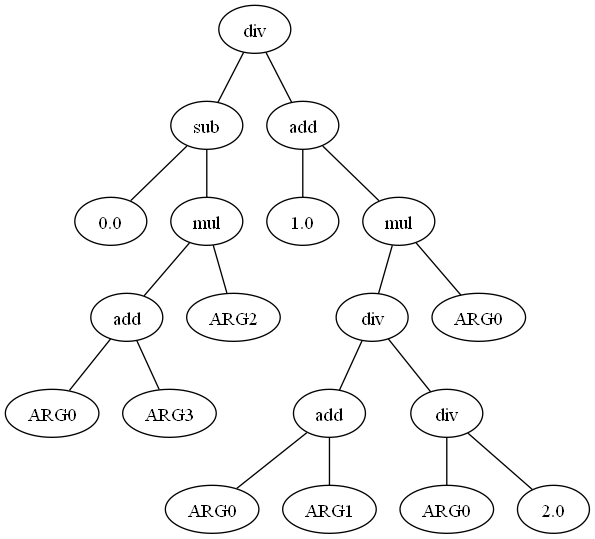

In [16]:
if pydot is None:
    warnings.warn("This display is not available due to a missing optional dependency (pydot)")
    
else:
    display(Image(plot_tree(hof[0])))

And now the accuracy of the best individual and its confusion matrix on the test data

In [17]:
sol = gp.compile(hof[0], pset)

predicted_classes = get_classes(sol, x_test)
accuracy = metrics.accuracy_score(y_test, predicted_classes)
print("Accuracy of the best individual:", accuracy)

Accuracy of the best individual: 0.8666666666666667


Confusion matrix of the best individual from our GP:
[[12  0  0]
 [ 1  8  2]
 [ 0  1  6]]


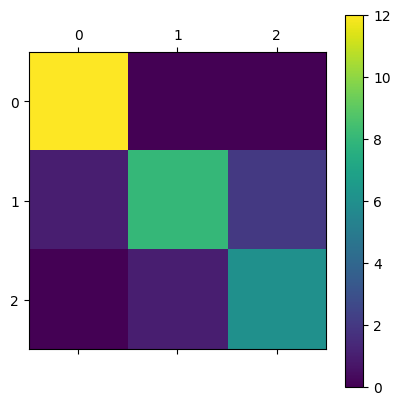

How the confusion matrix looks like for the perfect classifier:
[[12  0  0]
 [ 0 11  0]
 [ 0  0  7]]


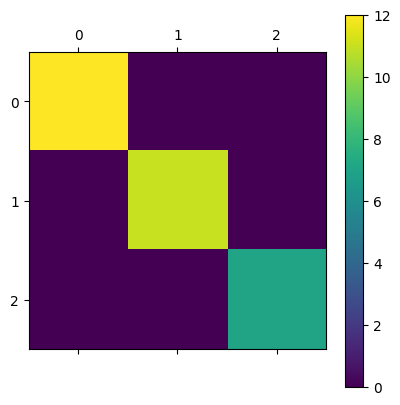

In [18]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted_classes)
print("Confusion matrix of the best individual from our GP:")
print(confusion_matrix)

pl.matshow(confusion_matrix)
pl.colorbar()
pl.show()

confusion_matrix = metrics.confusion_matrix(y_test, y_test)
print("How the confusion matrix looks like for the perfect classifier:")
print(confusion_matrix)

pl.matshow(confusion_matrix)
pl.colorbar()
pl.show()